# Earth-Relative versus Grid-Relative Winds: HRRR

_Do I really need to convert the grib2 file from grid relative to earth relative?_

That is the question I hope to answer with this notebook. The answer is yes, but the conversion is only necessary for vector quantities, like wind U and V components, of models on a rotated grid. The conversion from grid-relative to earth-relative is necessary becuase the grid-relative wind direction for some map projections is not oriented north-south. The [wgrib2: -new_grid_winds](http://www.cpc.ncep.noaa.gov/products/wesley/wgrib2/new_grid_winds.html) documentation states:

>For lat-lon, Mercator and Gaussian grids, the grid and earth relative directions are the same. For the Lambert conformal, polar stereographic and various rotated grids, the directions are different.

Since the CONUS HRRR is on a Lambert conformal projection, and the HRRR-Alaska is on a polar stereographic projection, it will be important to convert the winds from grid- to earth-relative winds.

The two most-used variables that need the conversion are `UGRD` and `VGRD`.

You can use the `wgrib2` command-line utility to make the conversion. The conversion requires using the `-new_grid` option, which will be demonstraed  in this notebook. 

Review the documentation here: http://www.cpc.ncep.noaa.gov/products/wesley/wgrib2/new_grid.html

----

The [formula](http://www2.mmm.ucar.edu/wrf/users/FAQ_files/Miscellaneous.html) to rotate the grid-relative winds to earth-relative is:

    u-earth = u-model*cosalpha - v-model*sinalpha
    v-earth = v-model*cosalpha + u-model*sinalpha
    
`cosalpha` and `sinalpha` are outputs of the WRF model and reprsent the "Local sine/cosine of map rotation".

----

To get started, we need to import a few libraries...

In [1]:
%matplotlib inline
import pygrib
import os
import numpy as np
import urllib
import matplotlib.pyplot as plt

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_wx_calcs.wind import wind_uv_to_spd, wind_uv_to_dir
from BB_basemap.draw_maps import draw_CONUS_HRRR_map, draw_CONUS_cyl_map, draw_ALASKA_cyl_map

We then download a HRRR file from the [Pando HRRR archive](hrrr.chpc.utah.edu/).

In [2]:
URL = 'https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20180425/hrrr.t00z.wrfsfcf00.grib2'
FILE = URL.split('/')[-1]
print 'File URL: %s' % URL
print 'File Name: %s' % FILE

File URL: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20180425/hrrr.t00z.wrfsfcf00.grib2
File Name: hrrr.t00z.wrfsfcf00.grib2


In [3]:
urllib.urlretrieve(URL, FILE)

('hrrr.t00z.wrfsfcf00.grib2', <httplib.HTTPMessage instance at 0x2b740f5b5e18>)

Using pygrib, we can plot the data to see what it looks like. As you will see, the model is projected on a rotated grid. 

In [4]:
grbs = pygrib.open(FILE)

In [5]:
# Check the grib messages to determine the number for the desired variable
U, lat, lon = grbs[59].data()
V, lat, lon = grbs[60].data()

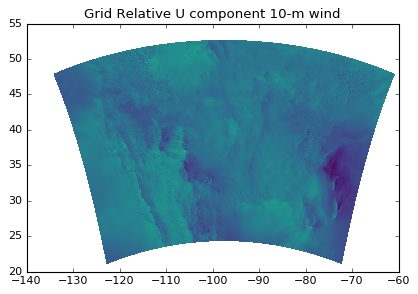

In [6]:
plt.pcolormesh(lon, lat, U, cmap='viridis')
plt.title('Grid Relative U component 10-m wind')

If you use the command `wgrib2 filename.grib2 -vector_dir` you will see the winds are labeled `(grid)`. We need to convert the U and V component to earth-relative or `(N/S)`.

If you look at the `-new_grid` documentation, you will realize that in order to change the orientation of the winds to earth-relative, you need to  create a whole new file and define the new grid. This is not intuitive, becuase you have to specify what the new grid should be. _But for the HRRR domain, we want it to be the same grid as it was before._ To find the grid format for the existing file, there is a perl script available in the `-new_grid` documentation called [`grid_defn.pl`](http://ftp.cpc.ncep.noaa.gov/wd51we/wgrib2.scripts/grid_defn.pl) that we can use to print out the grid format information we need to do the regriding. (If you or I feel ambitious, we would rewrite that perl script in Python, the true language).

I have already run this script for the downloaded HRRR file:

    perl grid_defn.pl hrrr.t00z.wrfsfcf00.grib2
>lambert:262.500000:38.500000:38.500000:38.500000 237.280472:1799:3000.000000 21.138123:1059:3000.000000

You can get that same information by using `wgrib2 -d 1 -grid hrrr.t00z.wrfsfcf00.grib2`

With that information, we can now complete the regridding function. **This is what you want to run in your terminal to regrid the CONUS HRRR grib2 file:**
    
    wgrib2 hrrr.t00z.wrfsfcf00.grib2 -new_grid_winds earth -new_grid lambert:262.500000:38.500000:38.500000:38.500000 237.280472:1799:3000.000000 21.138123:1059:3000.000000 hrrr.t00z.wrfsfcf00.grib2.regrid
    
After running that it will create a new HRRR file with the `.regrid` label on the end.

In [11]:
HRRR_grid = 'lambert:262.500000:38.500000:38.500000:38.500000 237.280472:1799:3000.000000 21.138123:1059:3000.000000'

os.system('wgrib2 %s -new_grid_winds earth -new_grid %s %s' % (FILE, HRRR_grid, FILE+'.earth'))

0

---

Now we can load the new regidded file so we can draw some comparisions.

In [12]:
grbs_regrid = pygrib.open(FILE+'.earth')

In [13]:
U_rg, lat_rg, lon_rg = grbs_regrid[59].data()
V_rg, lat_rg, lon_rg = grbs_regrid[60].data()

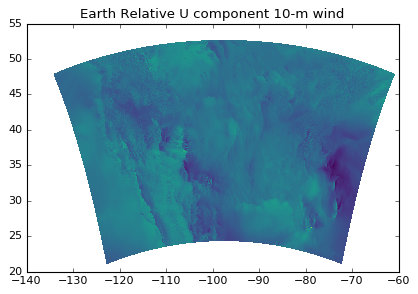

In [14]:
plt.pcolormesh(lon_rg, lat_rg, U_rg, cmap='viridis')
plt.title('Earth Relative U component 10-m wind')

First, I want to show that **the latitude/longitude values are the same** between the raw file and the regridded file.

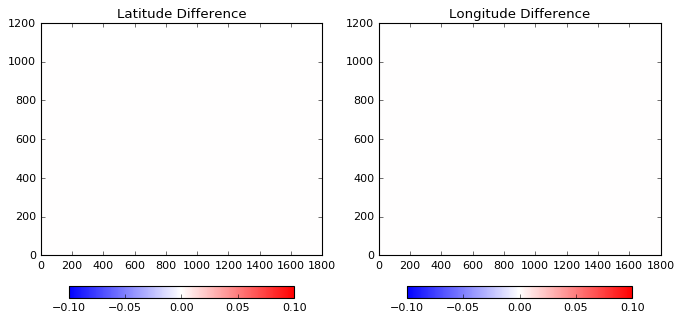

In [15]:
diff_lon = lon_rg-lon
diff_lat = lat_rg-lat

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10,5])
plt.sca(ax1)
plt.pcolormesh(diff_lat, cmap='bwr')
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
cb.set_ticks([-.1,-.05,0,.05,.1])
plt.title('Latitude Difference')

plt.sca(ax2)
plt.pcolormesh(diff_lon, cmap='bwr')
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
cb.set_ticks([-.1,-.05,0,.05,.1])
plt.title('Longitude Difference')

In [16]:
# Show that the difference is zero
print diff_lon.max(), diff_lon.min()
print diff_lat.max(), diff_lat.min()

0.0 0.0
0.0 0.0


Now I can show you the difference between the U and V wind components. Becuase we know the latitude and longitude are not differnt, we can plot them the difference on the model's latitude and longitude grid.

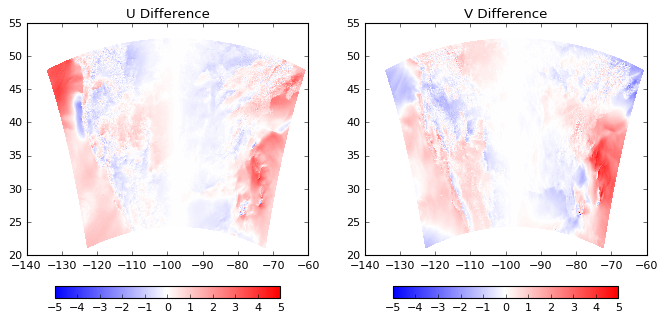

In [17]:
diff_U = U_rg-U
diff_V = V_rg-V

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10,5])
plt.sca(ax1)
plt.pcolormesh(lon, lat, diff_U, cmap='bwr', vmax=5, vmin=-5)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('U Difference')

plt.sca(ax2)
plt.pcolormesh(lon, lat, diff_V, cmap='bwr', vmax=5, vmin=-5)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('V Difference')

You would expect that since there are differences in U and V that the wind speed between the two would be different. They are actually very close the the same. The largest difference in wind speed is less than a one-tenth of a m/s.

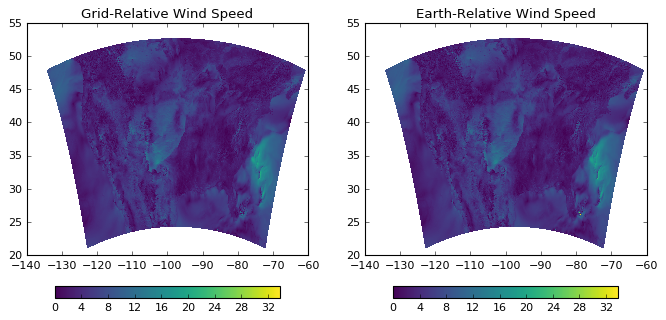

In [18]:
spd = wind_uv_to_spd(U,V)
spd_rg = wind_uv_to_spd(U_rg,V_rg)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10,5])
plt.sca(ax1)
plt.pcolormesh(lon, lat, spd, cmap='viridis', vmin=0)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('Grid-Relative Wind Speed')

plt.sca(ax2)
plt.pcolormesh(lon, lat, spd_rg, cmap='viridis', vmin=0)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('Earth-Relative Wind Speed')

Max difference 0.0549005191255
Min difference -0.0714914475896


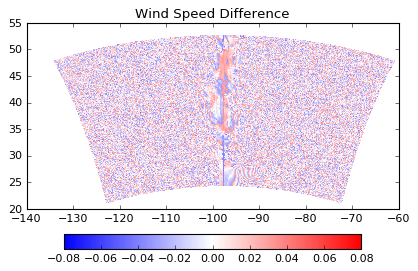

In [19]:
plt.pcolormesh(lon, lat, spd_rg-spd, cmap='bwr', vmin=-.08, vmax=.08)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('Wind Speed Difference')

print "Max difference", np.max(spd_rg-spd)
print "Min difference", np.min(spd_rg-spd)

**The biggest reason why we need earth-relative winds is for the wind direction.** This is evident when we plot the grid-relative and earth-relative wind barbs on a Basemap.

You will see below that **the largest error in wind direction is at the peripheries of the model domain**. Also, it doesn't matter whether the figure is plotted on a Lambert or cylindrical projection.

In [20]:
m = draw_CONUS_HRRR_map()
m2 = draw_CONUS_cyl_map()

In [21]:
direction = wind_uv_to_dir(U,V)
direction_rg = wind_uv_to_dir(U_rg,V_rg)

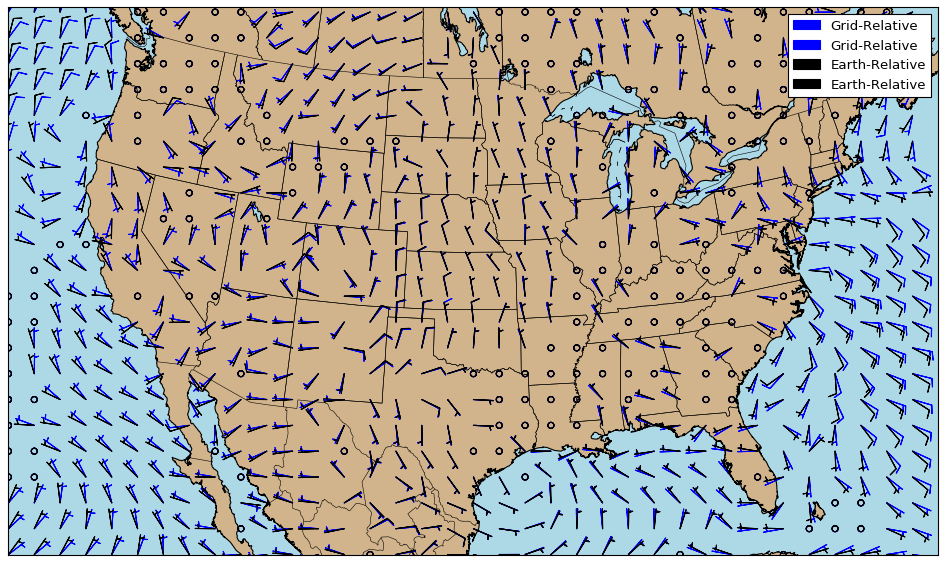

In [83]:
plt.figure(figsize=[15,10])
m.drawcountries()
m.drawstates()
m.drawcoastlines()
m.fillcontinents(color='tan',lake_color='lightblue', zorder=0)
m.drawmapboundary(fill_color='lightblue')


thin = 50

m.barbs(lon[::thin,::thin], lat[::thin,::thin], U[::thin,::thin], V[::thin,::thin],
        color='blue',
        length=6,
        latlon=True,
        label='Grid-Relative')
m.barbs(lon_rg[::thin,::thin], lat_rg[::thin,::thin], U_rg[::thin,::thin], V_rg[::thin,::thin],
        color='k',
        length=6,
        latlon=True,
        label='Earth-Relative')

plt.legend()

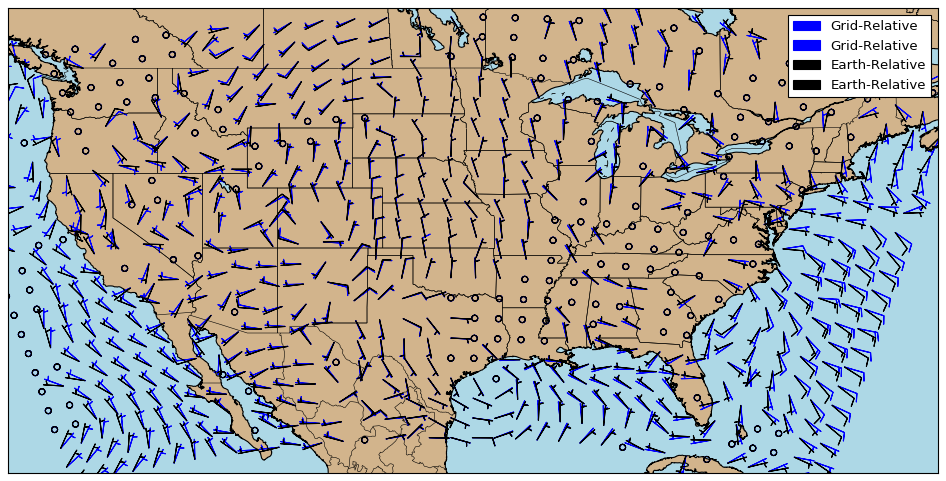

In [82]:
plt.figure(figsize=[15,10])
m2.drawcountries()
m2.drawstates()
m2.drawcoastlines()
m2.fillcontinents(color='tan',lake_color='lightblue', zorder=0)
m2.drawmapboundary(fill_color='lightblue')


thin = 50

m2.barbs(lon[::thin,::thin], lat[::thin,::thin], U[::thin,::thin], V[::thin,::thin],
        color='blue',
        length=6,
        latlon=True,
        label='Grid-Relative')
m2.barbs(lon_rg[::thin,::thin], lat_rg[::thin,::thin], U_rg[::thin,::thin], V_rg[::thin,::thin],
        color='k',
        length=6,
        latlon=True,
        label='Earth-Relative')

plt.legend()

## Notes about HRRR-Alaska
The Alaska grid is just weird. It is on a polar stereographic grid and requires a little extra work. But converting the winds to earth relative is much more important in Alaska than in the CONUS.

The grid definition as described by the `grid_defn.pl` script is:
>nps:225.000000:60.000000 185.117126:1299:3000.000000 41.612949:919:3000.000000

Taylor McCorkle used this regrid option instead to put it on a regular lat-lon domain (this is for the original HRRR-Alaska domain before the upgrade):
> latlon -175.75:1800:0.0269 46.863:1000:0.0269

I am going to use the first method, not Taylor's.

In [47]:
AK_URL = 'https://pando-rgw01.chpc.utah.edu/hrrrak/sfc/20180425/hrrrak.t00z.wrfsfcf00.grib2'
AK_FILE = AK_URL.split('/')[-1]
print 'File URL: %s' % AK_URL
print 'File Name: %s' % AK_FILE

File URL: https://pando-rgw01.chpc.utah.edu/hrrrak/sfc/20180425/hrrrak.t00z.wrfsfcf00.grib2
File Name: hrrrak.t00z.wrfsfcf00.grib2


In [48]:
urllib.urlretrieve(AK_URL, AK_FILE)

('hrrrak.t00z.wrfsfcf00.grib2',
 <httplib.HTTPMessage instance at 0x2b744a594998>)

Now make a regridded version with earth-relative winds

In [49]:
ALASKA_grid = 'nps:225.000000:60.000000 185.117126:1299:3000.000000 41.612949:919:3000.000000'

os.system('wgrib2 %s -new_grid_winds earth -new_grid %s %s' % (AK_FILE, ALASKA_grid, AK_FILE+'.earth'))

0

Using pygrib, we can plot the data to see what it looks like. As you will see, the model is projected on a rotated grid. 

In [51]:
# Grid Relative
AK_grbs = pygrib.open(FILE)
AK_U, AK_lat, AK_lon = AK_grbs[75].data()
AK_V, AK_lat, AK_lon = AK_grbs[76].data()

# Earth Relative
AK_grbs_rg = pygrib.open(FILE+'.earth')
AK_U_rg, AK_lat_rg, AK_lon_rg = AK_grbs_rg[75].data()
AK_V_rg, AK_lat_rg, AK_lon_rg = AK_grbs_rg[76].data()

We need to correct the funky issue with the longitude. Here is the secret sauce:

In [52]:
#Funky things going on with longitude
AK_lon[AK_lon>0] -= 360
AK_lon_rg[AK_lon_rg>0] -= 360

This is good, there is still no difference between the lat/lon in the regridded file

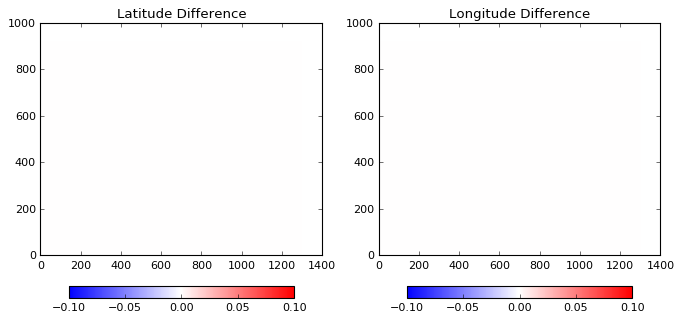

In [53]:
AK_diff_lon = AK_lon_rg-AK_lon
AK_diff_lat = AK_lat_rg-AK_lat

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10,5])
plt.sca(ax1)
plt.pcolormesh(AK_diff_lat, cmap='bwr')
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
cb.set_ticks([-.1,-.05,0,.05,.1])
plt.title('Latitude Difference')

plt.sca(ax2)
plt.pcolormesh(AK_diff_lon, cmap='bwr')
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
cb.set_ticks([-.1,-.05,0,.05,.1])
plt.title('Longitude Difference')

And just as we expected, there are differences in the U and V field

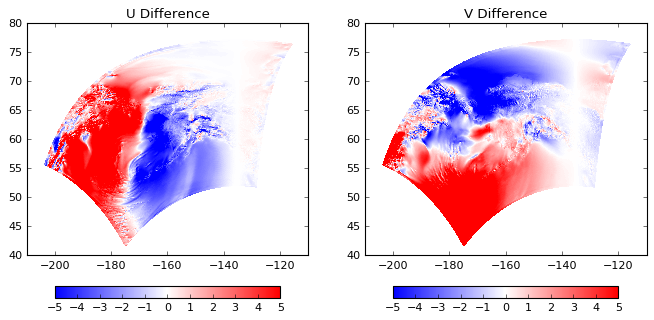

In [54]:
AK_diff_U = AK_U_rg-AK_U
AK_diff_V = AK_V_rg-AK_V

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10,5])
plt.sca(ax1)
plt.pcolormesh(AK_lon, AK_lat, AK_diff_U, cmap='bwr', vmax=5, vmin=-5)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('U Difference')

plt.sca(ax2)
plt.pcolormesh(AK_lon, AK_lat, AK_diff_V, cmap='bwr', vmax=5, vmin=-5)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('V Difference')

But minor differences in the wind speed

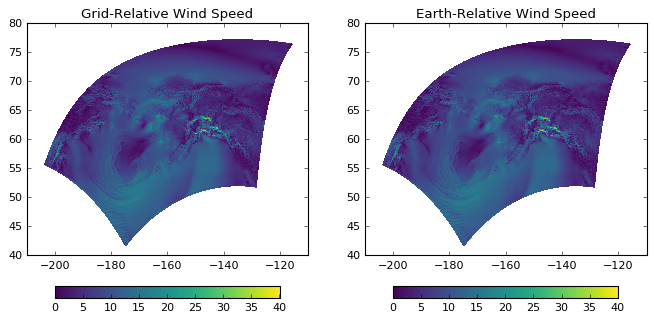

In [55]:
AK_spd = wind_uv_to_spd(AK_U,AK_V)
AK_spd_rg = wind_uv_to_spd(AK_U_rg, AK_V_rg)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10,5])
plt.sca(ax1)
plt.pcolormesh(AK_lon, AK_lat, AK_spd, cmap='viridis', vmin=0)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('Grid-Relative Wind Speed')

plt.sca(ax2)
plt.pcolormesh(AK_lon, AK_lat, AK_spd_rg, cmap='viridis', vmin=0)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('Earth-Relative Wind Speed')

Max difference 0.0549005191255
Min difference -0.0714914475896


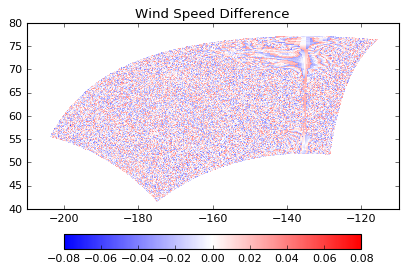

In [57]:
plt.pcolormesh(AK_lon, AK_lat, AK_spd_rg-AK_spd, cmap='bwr', vmin=-.08, vmax=.08)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('Wind Speed Difference')

print "Max difference", np.max(spd_rg-spd)
print "Min difference", np.min(spd_rg-spd)

Now draw the wind vectors to visualize the difference in wind speed

In [68]:
m3 = draw_ALASKA_cyl_map()

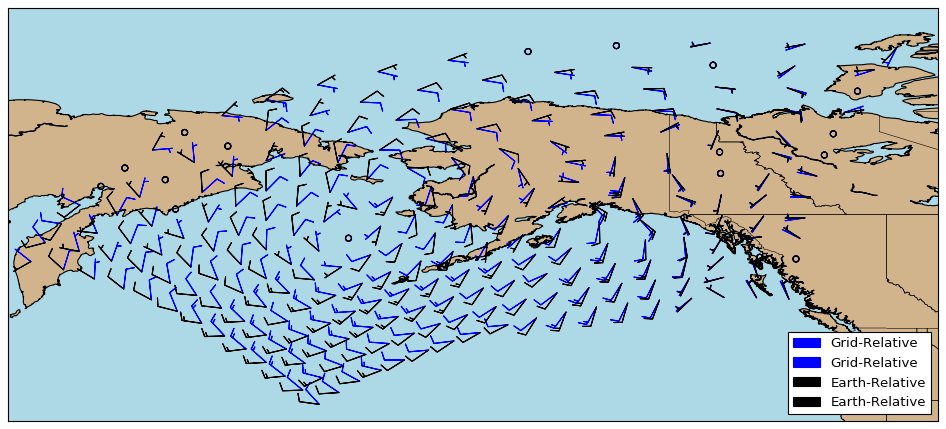

In [81]:
plt.figure(figsize=[15,10])

m3.drawcountries()
m3.drawstates()
m3.drawcoastlines()
m3.fillcontinents(color='tan',lake_color='lightblue', zorder=0)
m3.drawmapboundary(fill_color='lightblue')

thin = 75

m3.barbs(AK_lon[::thin,::thin], AK_lat[::thin,::thin], AK_U[::thin,::thin], AK_V[::thin,::thin],
        color='blue',
        length=6,
        latlon=True,
        label='Grid-Relative')
m3.barbs(AK_lon_rg[::thin,::thin], AK_lat_rg[::thin,::thin], AK_U_rg[::thin,::thin], AK_V_rg[::thin,::thin],
        color='k',
        length=6,
        latlon=True,
        label='Earth-Relative')

plt.legend(loc=4)